# Apply SVM on Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


## Objective:
#### Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




##### * I am applying  Linear SVM  on 100k points because of low system configration(4GB RAM and 1.3GHz processor) and automatic system shut down issue due to heat up.
#### * I am applying RBF SVM on 20k points due low system configration(4GB RAM and 1.3GHz processor).

#### ----->>> Important note-->> I have applied Linear SVM   on 100k on brute and 20k on RBF SVM seperately, from 100k points that i  filtered data earlier i have sample out 20k points and apply RBF SVM  on it.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\HIMANSHU NEGI\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [227]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [228]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [229]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [230]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [231]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#### note: From here you will see the code is written one after the another cell for Linear SVM version and RBF SVM version it is only for redability steps of code but 1st we have run all steps for Linear SVM version  and then we did it for RBF SVM.

#### Here we have done sampling of points we have taken 7592 -ve and 12408 +ve points from 50k points for brute version.


In [167]:
data_pos =final[final["Score"] == 1].sample(n = 12408)
data_neg = final[final["Score"] == 0].sample(n = 7592)
final = pd.concat([data_pos, data_neg])
final.shape

(20000, 10)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [232]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [233]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [234]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [235]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [236]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [237]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [238]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [239]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [240]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:53<00:00, 1635.15it/s]


In [177]:
#code for BRUTE version
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1603.58it/s]


In [178]:
preprocessed_reviews[1500]

'granola outside make appealing flavored rawhide uploaded photos show rawhide granola layer sum dog getting rest life loves rawhide keeps teeth healthy no brainer probably favorite rawhide treat also loves regular busy rollhide busy chewnola even better'

# Applying SVM

In [28]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [29]:
#spilliting data 
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

## [5.1] Linear SVM

In [116]:
#code for VECTORIZER
count_vect = CountVectorizer(min_df = 10) 
Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 8148)
the number of unique words : 8148


In [117]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

### [5.1.1] Applying Linear SVM on BOW with L1,<font color='red'> SET 1</font>

In [32]:
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

In [34]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

In [45]:
r=[]
import math
for p in (hyper):
    q=math.log(p)
    r.append(q)
print(r)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.9667310506601865, 0.9271262370865652, 0.7762103934029168, 0.5705727116243767, 0.5147282477233888, 0.5, 0.5, 0.5, 0.5]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8939208771241369, 0.8726707728897894, 0.7566582160661185, 0.5741647936561585, 0.5119730694846976, 0.5, 0.5, 0.5, 0.5]


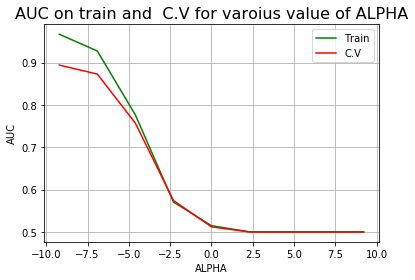

In [46]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [61]:
svm = SGDClassifier(loss='hinge',penalty='l1',alpha=.001)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L1 regulariser for alpha = %f is %f%%' % (0.001, acc))


The accuracy of the linear svm classifier with L1 regulariser for alpha = 0.001000 is 86.522102%


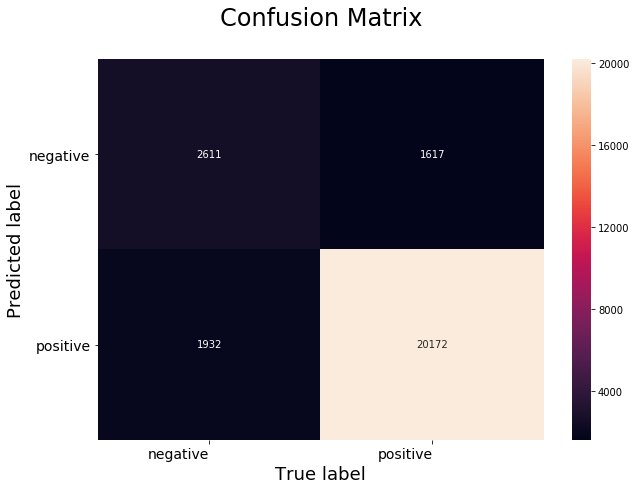

In [62]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [86]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

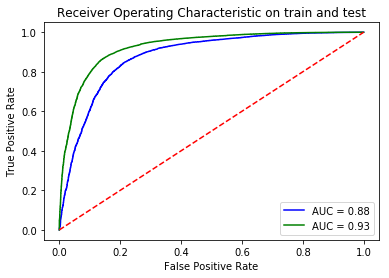

In [87]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [65]:
w=svm.coef_
print(w)

[[-14.88872554   0.          39.35130017 ...   0.         -38.87412358
    0.        ]]


In [69]:
absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 positive features with their weight values for L1 :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 positive features with their weight values for L1 :
       fromm	--> 	335.910044
      straws	--> 	333.095829
      napkin	--> 	316.198722
    croutons	--> 	307.975697
  consistant	--> 	304.643776
       brian	--> 	303.111915
    scratchy	--> 	301.810365
   resistant	--> 	296.149228
      weekly	--> 	292.631606
          bi	--> 	281.819013


In [70]:

absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values for L1 :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values for L1 :
       zukes	--> 	0.000000
grandchildren	--> 	0.000000
granddaughter	--> 	0.000000
   grandkids	--> 	0.000000
     grandma	--> 	0.000000
 grandmother	--> 	0.000000
grandparents	--> 	0.000000
    grandson	--> 	0.000000
    granolas	--> 	0.000000
     granted	--> 	0.000000


# [5.1.1] Applying Linear SVM on BOW with L2,<font color='red'> SET 1</font>

In [88]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

In [89]:
r=[]
import math
for p in (hyper):
    q=math.log(p)
    r.append(q)
print(r)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.988572236698899, 0.988635471881493, 0.9892153280253575, 0.9818603847370624, 0.9340427910501858, 0.6611561981969074, 0.5389673529988479, 0.5341954740515681, 0.534195939402947]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8980710045421283, 0.8965515156584152, 0.9024191196901516, 0.9145238183799808, 0.8840863219808512, 0.6426118338839432, 0.5340468813355185, 0.529703556888063, 0.5297042890912067]


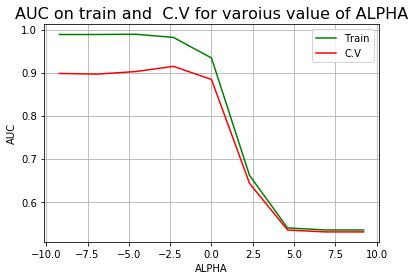

In [90]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [118]:
svm = SGDClassifier(loss='hinge',penalty='l2',alpha=1)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L2 regulariser for alpha = %f is %f%%' % (1, acc))


The accuracy of the linear svm classifier with L2 regulariser for alpha = 1.000000 is 89.898223%


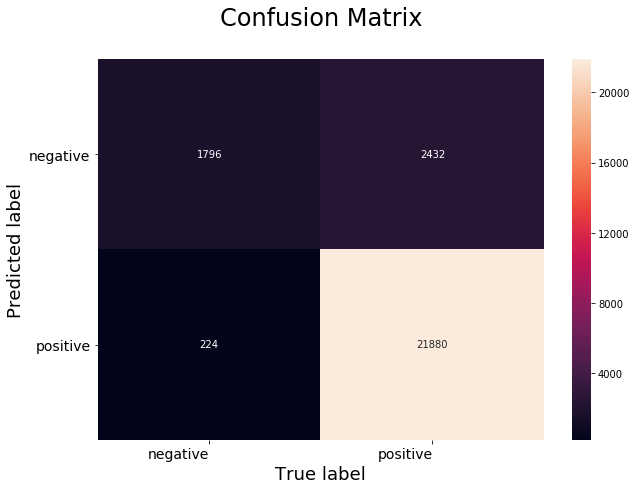

In [92]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [119]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

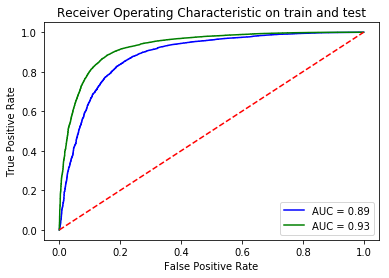

In [120]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [117]:
w=svm.coef_
print(w)

[[-2.05601925e-02  2.14481352e-16  4.49883936e-02 ...  6.55584509e-16
   1.36781099e-02 -2.97641271e-02]]


In [118]:
absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 positive features with their weight values  :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 positive features with their weight values  :
       fromm	--> 	0.031708
      straws	--> 	0.000000
      napkin	--> 	-0.017320
    croutons	--> 	-0.055681
  consistant	--> 	0.051550
       brian	--> 	0.093622
    scratchy	--> 	0.029077
   resistant	--> 	0.000000
      weekly	--> 	0.079506
          bi	--> 	0.025775


In [119]:

absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values :
       zukes	--> 	-0.029764
grandchildren	--> 	0.065645
granddaughter	--> 	0.000000
   grandkids	--> 	0.046337
     grandma	--> 	0.010994
 grandmother	--> 	0.024909
grandparents	--> 	0.027840
    grandson	--> 	0.063891
    granolas	--> 	0.043129
     granted	--> 	-0.011373


### [5.1.2] Applying Linear SVM on TFIDF with L1,<font color='red'> SET 2</font>

In [95]:
#code for VECTORIZER
count_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=10)

Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 25715)
the number of unique words : 25715


In [96]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [97]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

In [98]:
r=[]
import math
for p in (hyper):
    q=math.log(p)
    r.append(q)
print(r)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.9880734528583088, 0.9479113911247707, 0.7618337813675711, 0.6126314140660272, 0.49027429376281817, 0.5021021540399094, 0.5, 0.5, 0.5]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9205958744495035, 0.8885220713851203, 0.7458848405121389, 0.6123855571716558, 0.4909626048792093, 0.5024799302072331, 0.5, 0.5, 0.5]


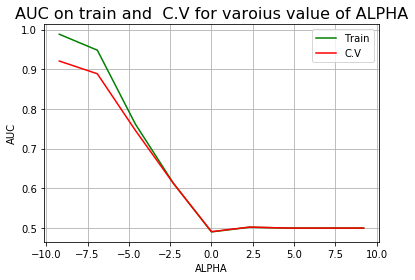

In [99]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [100]:
svm = SGDClassifier(loss='hinge',penalty='l1',alpha=.01)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L1 regulariser for alpha = %f is %f%%' % (0.01, acc))


The accuracy of the linear svm classifier with L1 regulariser for alpha = 0.010000 is 81.664894%


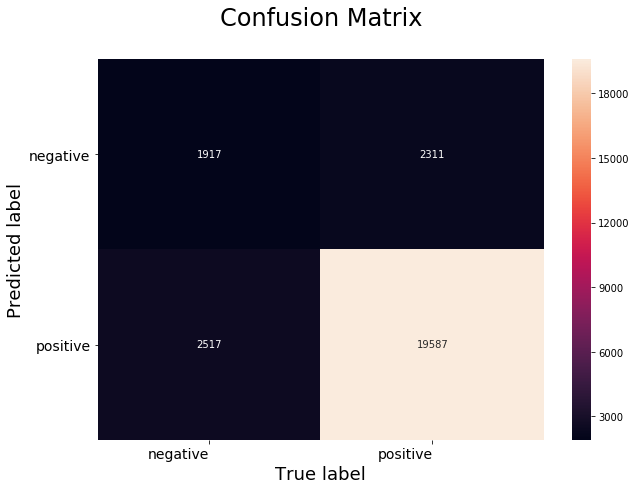

In [101]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [103]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

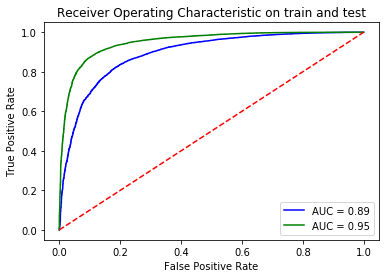

In [104]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
w=svm.coef_
print(w)

[[0.         0.         7.52877624 ... 0.         0.         0.        ]]


In [92]:
absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 positive features with their weight values  :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 positive features with their weight values  :
      buying	--> 	0.000000
   ever made	--> 	0.000000
could afford	--> 	0.000000
 beef flavor	--> 	0.000000
        bait	--> 	-149.594458
amazon stock	--> 	0.000000
      duncan	--> 	0.000000
    dogs eat	--> 	0.000000
flavor artificial	--> 	0.000000
      altoid	--> 	0.000000


In [93]:

absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values :
flavors taste	--> 	0.000000
        cans	--> 	0.000000
cans arrived	--> 	0.000000
   cans cans	--> 	0.000000
 cans dented	--> 	0.000000
    cans not	--> 	0.000000
        cant	--> 	0.000000
   cant find	--> 	0.000000
   cant wait	--> 	0.000000
         cap	--> 	0.000000


### [5.1.2] Applying Linear SVM on TFIDF with L2,<font color='red'> SET 2</font>

In [110]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

In [106]:
r=[]
import math
for p in (hyper):
    q=math.log(p)
    r.append(q)
print(r)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.9996341366993631, 0.9996686414924763, 0.9997452545155806, 0.9998313242880114, 0.9925560086904491, 0.8928054884205262, 0.6972626134067886, 0.6972559689984045, 0.697257053469444]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9275123908645986, 0.9265826183927506, 0.9310804795436878, 0.9341750838299379, 0.9402717837652657, 0.8262894484380663, 0.6571234307474525, 0.6571171547205075, 0.6571172384008666]


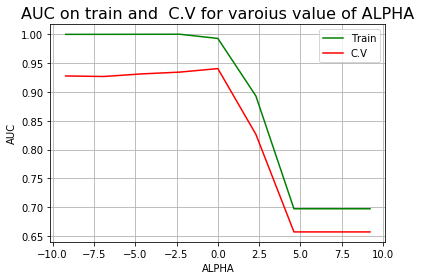

In [111]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [112]:
svm = SGDClassifier(loss='hinge',penalty='l2',alpha=1)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L2 regulariser for alpha = %f is %f%%' % (1, acc))


The accuracy of the linear svm classifier with L2 regulariser for alpha = 1.000000 is 91.322345%


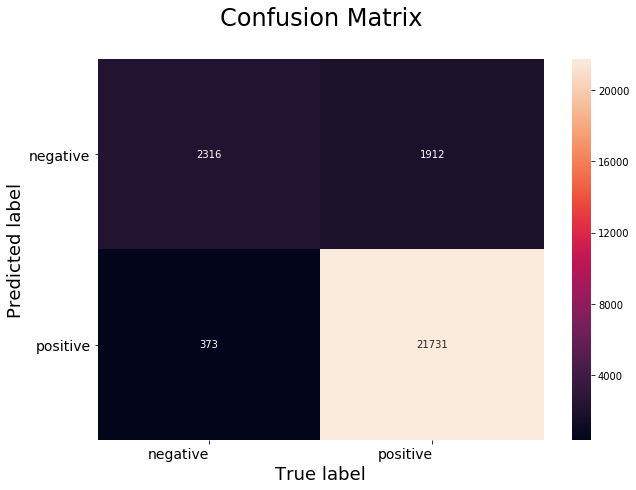

In [113]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [114]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=1))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

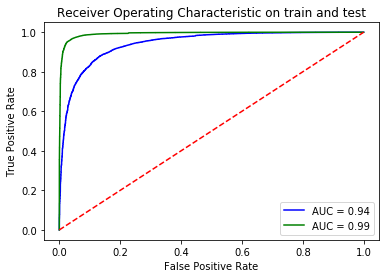

In [115]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
w=svm.coef_
print(w)

[[-0.0057084  -0.00259597  0.01282531 ... -0.00167813  0.01354062
  -0.00096587]]


In [105]:
absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 positive features with their weight values  :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 positive features with their weight values  :
      buying	--> 	0.006047
   ever made	--> 	0.000927
could afford	--> 	0.003290
 beef flavor	--> 	-0.002418
        bait	--> 	-0.017180
amazon stock	--> 	0.012121
      duncan	--> 	-0.011562
    dogs eat	--> 	0.009445
flavor artificial	--> 	-0.000658
      altoid	--> 	0.008386


In [106]:

absolute_weights = np.absolute(W)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = svm.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values :
flavors taste	--> 	0.004437
        cans	--> 	-0.007679
cans arrived	--> 	0.012712
   cans cans	--> 	-0.009946
 cans dented	--> 	-0.004708
    cans not	--> 	0.000925
        cant	--> 	-0.000872
   cant find	--> 	-0.008476
   cant wait	--> 	0.011140
         cap	--> 	0.000085


### [5.1.3]  Applying Linear SVM on AVG W2V with L1,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [121]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_tr:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
    sent_of_cv=[]
for sent in X_cv:
    sent_of_cv.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12674


In [122]:
# compute average word2vec for each review for X_train .
Xbow_tr = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_tr.append(sent_vec)
    
# compute average word2vec for each review for X_test .
Xbow_test = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_test.append(sent_vec)
  #gdfghsdgfsdgfhsdgfdhsgfhgdhgfhdghfg


    Xbow_cv = []; 
for sent in sent_of_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_cv.append(sent_vec)

In [123]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [125]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8912439351007695, 0.8955738880528953, 0.8947926804371747, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8881450076862503, 0.8931000355599688, 0.891516803162582, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


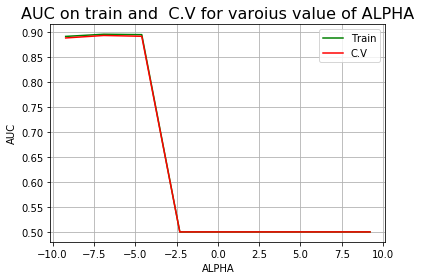

In [126]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [127]:
svm = SGDClassifier(loss='hinge',penalty='l1',alpha=.01)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L1 regulariser for alpha = %f is %f%%' % (0.01, acc))


The accuracy of the linear svm classifier with L1 regulariser for alpha = 0.010000 is 85.401792%


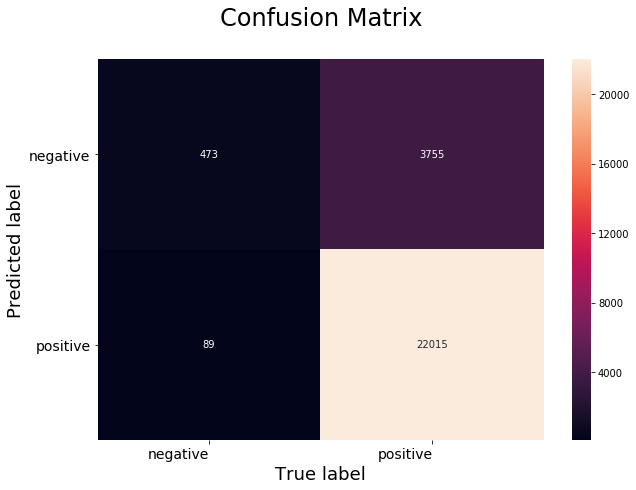

In [128]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [129]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

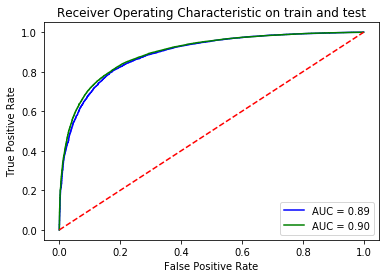

In [130]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V with L2,<font color='red'> SET 3</font>

In [131]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8904938170036942, 0.8982891202785899, 0.8972847827464802, 0.8969082568294654, 0.8982172376534155, 0.7624823941893037, 0.6276874755333925, 0.6276869939958787, 0.6276873379512458]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8866426732761876, 0.8950794735384084, 0.894807198569434, 0.8933093619786824, 0.8944921210966931, 0.759399448655217, 0.6309874186161435, 0.6309869374540777, 0.6309874395362334]


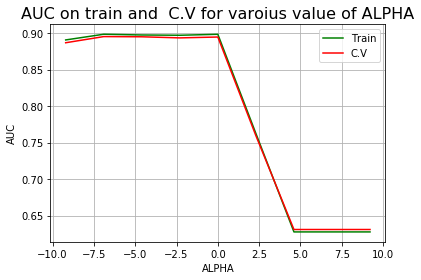

In [132]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [135]:
svm = SGDClassifier(loss='hinge',penalty='l2',alpha=.1)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L2 regulariser for alpha = %f is %f%%' % (.1, acc))


The accuracy of the linear svm classifier with L2 regulariser for alpha = 0.100000 is 85.272672%


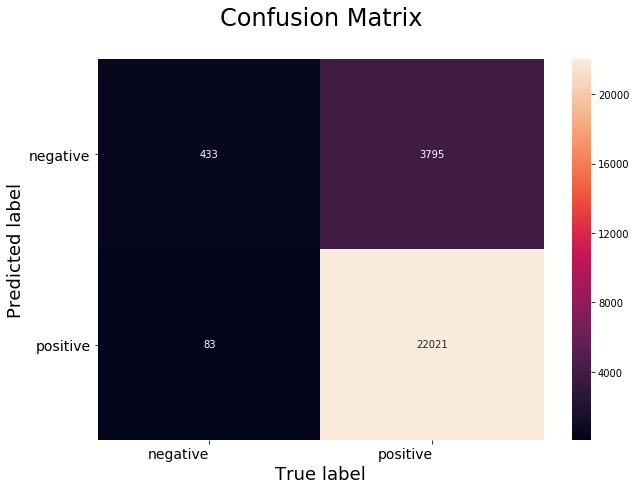

In [136]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [141]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=.1))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

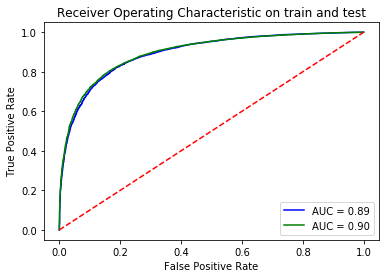

In [142]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V with L1,<font color='red'> SET 4</font>

In [139]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [143]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_tr.append(sent_vec)
    row += 1

In [144]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [145]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_cv.append(sent_vec)
    row += 1

In [146]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [147]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_test.append(sent_vec)
    row += 1

In [148]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [149]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8655091985865441, 0.8683690701138731, 0.8502932160829143, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8650698138961362, 0.8657790467811283, 0.8482065897362441, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


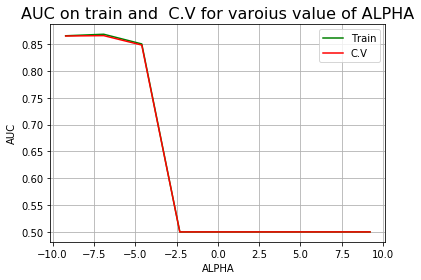

In [150]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [151]:
svm = SGDClassifier(loss='hinge',penalty='l1',alpha=.01)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L1 regulariser for alpha = %f is %f%%' % (0.01, acc))


The accuracy of the linear svm classifier with L1 regulariser for alpha = 0.010000 is 83.943491%


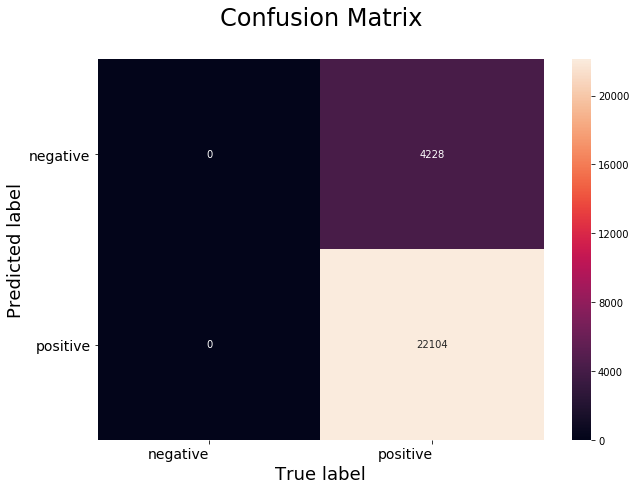

In [152]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [153]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

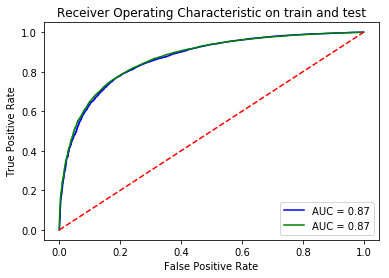

In [154]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V with L2,<font color='red'> SET 4</font>

In [157]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=j))
    model.fit(Xbow_tr_std, y_tr)
    
   

     
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8589471128845773, 0.8688992671958068, 0.8698248713211378, 0.869781617922101, 0.8709695709687296, 0.7186840241759834, 0.6135074178041665, 0.6135077941318035, 0.6135070212438609]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8555051069914061, 0.8669350491042623, 0.8679879153845964, 0.8684885958941981, 0.8690217234631067, 0.7187065895061232, 0.6184433561999678, 0.6184439628825725, 0.6184437536816743]


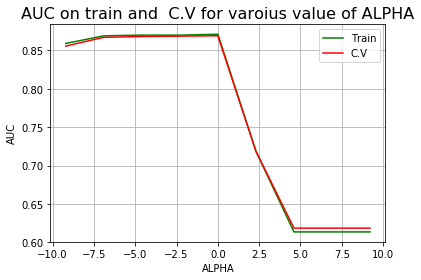

In [158]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of ALPHA',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [163]:
svm = SGDClassifier(loss='hinge',penalty='l2',alpha=.10)

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the linear svm classifier with L2 regulariser for alpha = %f is %f%%' % (.1, acc))


The accuracy of the linear svm classifier with L2 regulariser for alpha = 0.100000 is 83.954884%


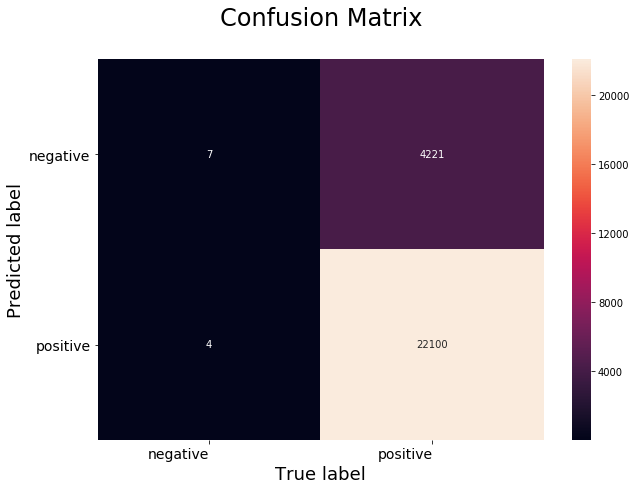

In [164]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [165]:
svm = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=.001))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

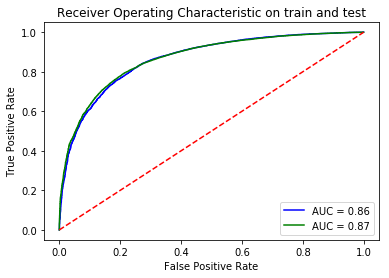

In [166]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.2] RBF SVM

In [179]:
# spilliting data for kd-Tree version of KNN
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [180]:
# spilliting data for kd-Tree version of KNN
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

In [181]:
#code for VECTORIZER
count_vect = CountVectorizer(min_df = 10,max_features=500) 
Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (9800, 500)
the number of unique words : 500


In [182]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [183]:
from sklearn.svm import SVC

In [184]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SVC(C=j, kernel='rbf'))
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8652479430682178, 0.9399529939414413, 0.9403563348164875, 0.9404462130674619, 0.9737979784061056, 0.9968275688866565, 0.9996224624507158, 0.9992698836738958, 0.999282907574754]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8370839619879072, 0.8990821743309079, 0.8996795813394743, 0.899716573972896, 0.90526138538373, 0.9006747792632749, 0.8886569776393942, 0.882475604679424, 0.8814578268365222]


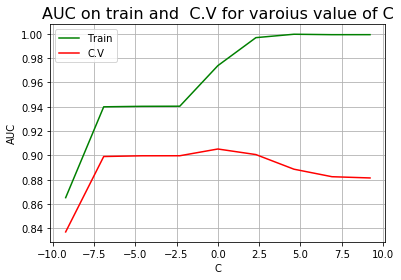

In [185]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C',size=10)
plt.grid()
plt.legend()
plt.show()


In [186]:
svm = SVC(C=.1,kernel='rbf')

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the RBF svm classifier for C = %f is %f%%' % (.1,acc))


The accuracy of the RBF svm classifier for C = 0.100000 is 70.900000%


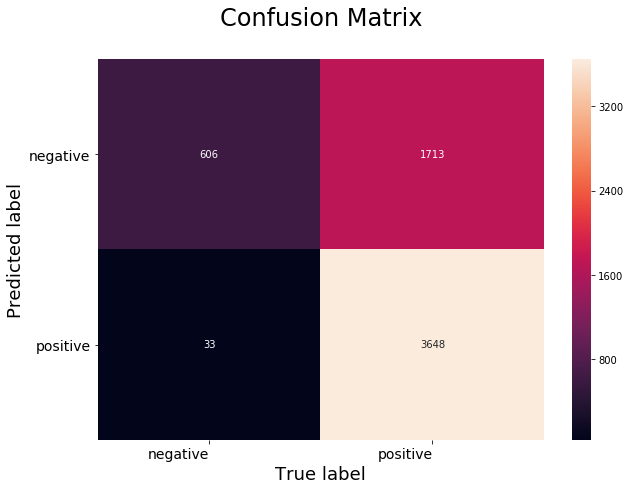

In [187]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [189]:
svm = CalibratedClassifierCV(SVC(C=.1,kernel='rbf'))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

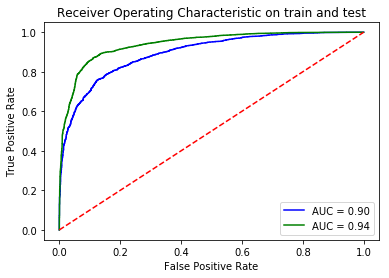

In [190]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [191]:
#code for VECTORIZER
count_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features = 500)

Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (9800, 500)
the number of unique words : 500


In [192]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [193]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SVC(C=j, kernel='rbf'))
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8939910921852148, 0.9385366113854674, 0.9386398246885154, 0.9387750421165395, 0.9859130732405509, 0.9986880086766738, 0.9986890754808397, 0.9986890754808397, 0.9986890754808397]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8531092188284818, 0.8976978331204656, 0.8975582700034662, 0.8976606002751387, 0.9090269472117525, 0.9117881830635712, 0.9117257279681844, 0.9117257279681844, 0.9117257279681844]


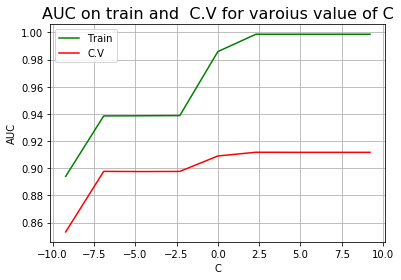

In [194]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C',size=10)
plt.grid()
plt.legend()
plt.show()


In [199]:

svm=SVC(C=1, kernel='rbf')

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the RBF svm classifier for C= %f is %f%%' % (1, acc))


The accuracy of the RBF svm classifier for C= 1.000000 is 83.150000%


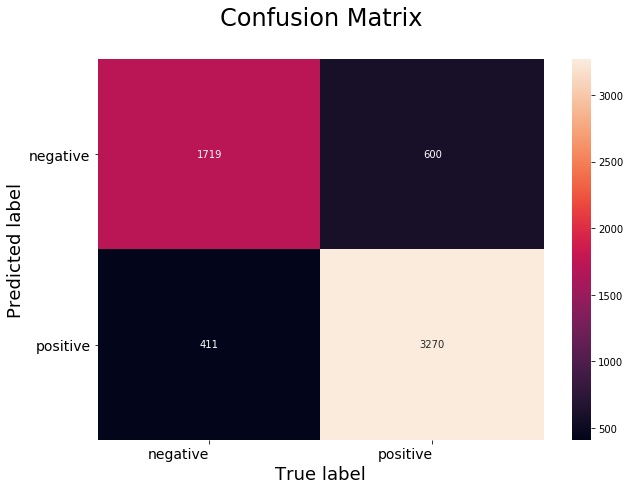

In [200]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [201]:
svm = CalibratedClassifierCV(SVC(C=1,kernel='rbf'))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

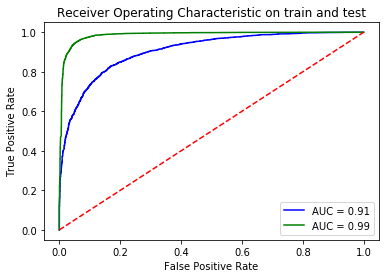

In [202]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [203]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_tr:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
    sent_of_cv=[]
for sent in X_cv:
    sent_of_cv.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  6133


In [204]:
# compute average word2vec for each review for X_train .
Xbow_tr = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_tr.append(sent_vec)
    
# compute average word2vec for each review for X_test .
Xbow_test = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_test.append(sent_vec)
  #gdfghsdgfsdgfhsdgfdhsgfhgdhgfhdghfg


    Xbow_cv = []; 
for sent in sent_of_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_cv.append(sent_vec)

In [205]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [206]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SVC(C=j, kernel='rbf'))
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8182471740802146, 0.8159561676838349, 0.8158223726613653, 0.8524033986602717, 0.8854248992092313, 0.917357237155011, 0.9566203866276098, 0.9800578519009118, 0.9721488769663647]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8188653302397242, 0.8177814941228554, 0.817626077020104, 0.8466804276060169, 0.8636833469013024, 0.8618099342515994, 0.8394051296291538, 0.8145809106961798, 0.7945373891031713]


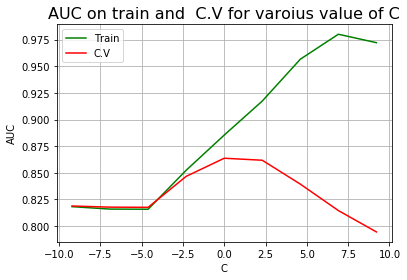

In [207]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C',size=10)
plt.grid()
plt.legend()
plt.show()


In [208]:
svm=SVC(C=.1, kernel='rbf')

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the RBF svm classifier  for C = %f is %f%%' % (.1, acc))


The accuracy of the RBF svm classifier  for C = 0.100000 is 76.866667%


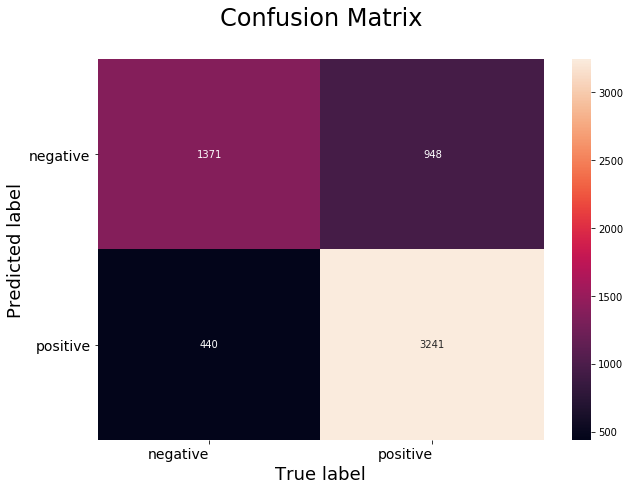

In [209]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [210]:
svm = CalibratedClassifierCV(SVC(C=1,kernel='rbf'))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

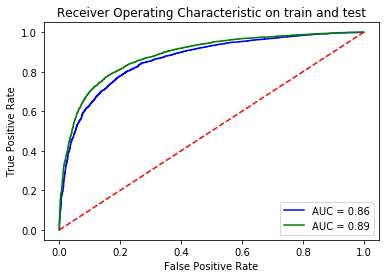

In [211]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [212]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [213]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_tr.append(sent_vec)
    row += 1

In [214]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [215]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_cv.append(sent_vec)
    row += 1

In [216]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [217]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_test.append(sent_vec)
    row += 1

In [218]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [219]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = CalibratedClassifierCV(SVC(C=j, kernel='rbf'))
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.801096519106907, 0.7977118161896423, 0.7976522974072213, 0.827692258113268, 0.8697690591231758, 0.9046491547799496, 0.9431630521267186, 0.9713353054393677, 0.9693804757057577]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.7934545138339237, 0.7913387273717383, 0.7912181409952606, 0.8156942928774047, 0.8396645584869149, 0.8465288538937508, 0.8345391570627946, 0.807642870234406, 0.788887605089706]


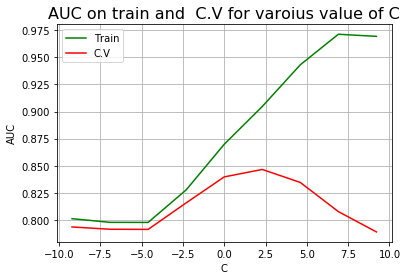

In [221]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C',size=16)
plt.plot(r, auc1,'g',label ='Train')
plt.plot(r, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C',size=10)
plt.grid()
plt.legend()
plt.show()


In [222]:
svm=SVC(C=.01, kernel='rbf')

# fitting the model
svm.fit(Xbow_tr_std, y_tr)

# predict the response
pred = svm.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the RBF svm classifier for C = %f is %f%%' % (.01, acc))


The accuracy of the RBF svm classifier for C = 0.010000 is 61.850000%


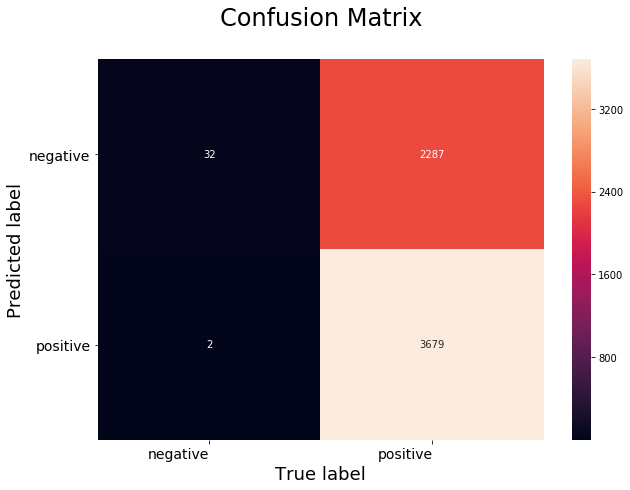

In [223]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [224]:
svm = CalibratedClassifierCV(SVC(C=1,kernel='rbf'))


svm.fit(Xbow_tr_std, y_tr)
probs2 = svm.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = svm.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

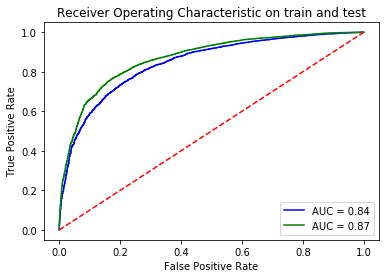

In [225]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [226]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vactorizer", "Model","Panelty", "Hyperparameter(C)", "AUC%"]

x.add_row(["BOW", "LinearSVM","L1",0.001,86.522102])
x.add_row(["BOW", "LinearSVM", "L2", 1,89.898223])
x.add_row(["TFIDF", "LinearSVM","L1",0.01,81.664894])
x.add_row(["TFIDF", "LinearSVM", "L2", 1,91.322345])
x.add_row(["AVGW2V", "LinearSVM","L1",0.01,85.401792])
x.add_row(["AVGW2V", "LinearSVM", "L2",0.1,85.272672])
x.add_row(["TFIDFW2V","LinearSVM", "L1",0.01,83.943491])
x.add_row(["TFIDFW2V","LinearSVM", "L2",0.1,83.954884])
x.add_row(["BOW", "RBF-SVC", "NONE",.1,70.900000])
x.add_row(["TFIDF","RBF-SVC", "NONE",1,83.150000])
x.add_row(["AVGW2V", "RBF-SVC","NONE",0.1, 76.866667])
x.add_row(["TFIDFW2V","RBF-SVC","NONE",0.01,61.850000])
print(x)

+------------+-----------+---------+-------------------+-----------+
| Vactorizer |   Model   | Panelty | Hyperparameter(C) |    AUC%   |
+------------+-----------+---------+-------------------+-----------+
|    BOW     | LinearSVM |    L1   |       0.001       | 86.522102 |
|    BOW     | LinearSVM |    L2   |         1         | 89.898223 |
|   TFIDF    | LinearSVM |    L1   |        0.01       | 81.664894 |
|   TFIDF    | LinearSVM |    L2   |         1         | 91.322345 |
|   AVGW2V   | LinearSVM |    L1   |        0.01       | 85.401792 |
|   AVGW2V   | LinearSVM |    L2   |        0.1        | 85.272672 |
|  TFIDFW2V  | LinearSVM |    L1   |        0.01       | 83.943491 |
|  TFIDFW2V  | LinearSVM |    L2   |        0.1        | 83.954884 |
|    BOW     |  RBF-SVC  |   NONE  |        0.1        |    70.9   |
|   TFIDF    |  RBF-SVC  |   NONE  |         1         |   83.15   |
|   AVGW2V   |  RBF-SVC  |   NONE  |        0.1        | 76.866667 |
|  TFIDFW2V  |  RBF-SVC  |   NONE 

#### ------>>> My system configration is 4GB RAM and 1.3 GHz processor ------>>> We have done all below steps saparately for Linear SVM and RBF-SVC version. ------>>> WE have taken 100k points for Linear SVM and 20k points for RBF-SVC  version

STEP 1 :- Data cleaning (removing duplication).

STEP 2 :- Text Preprocessing.

STEP 3:- Featurization on text reviews i.e BOW,TFIDF,avgW2V,TFIDF-W2V.

STEP 4:- Standardization on vectors i.e BOW,TFIDF,avgW2V,TFIDF-W2V.

STEP 5:- Using AUC as a metric using CalibratedClassifierCV and plot curve for train(predected value on itself) and C.V predected value on train VS C for various values.

STEP 6:- Plot "AUC VS C" to analise overfitting and underfitting.

STEP 7:- Once , we analise optimal value of C then train MODEL again with this analised optimal C and make predictions on test_data.  

STEP 8:- Compute test accuracy using predicted values of test_data.

STEP 9:- Plot Seaborn Heatmap for representation of Confusion Matrix on different SVM model.

STEP 10:- Plot ROC curve for train and test on different SVM model.

----->>>> Repeat from STEP 4 to STEP 10 for each of these four vectorizers : Bag Of Words(BoW), TFIDF , Avg Word2Vec and TFIDF Word2Vec saparately on Linear SVM (FOR both L1 and L2) and  RBF-SVC version of SVM as we have taken different no. of points for different versions.

------>>>> We extract the top 10 important features from positive class and negative class from SET1 and SET2 i.e BOW AND TFIDF vectorizer in Linear-SVM.

--------------->>>>> AT THE END WE MAKE A TABLE TO COMPAIR OUR RESULTS OF SVM WITH DIFFERENT VECTORIZERS AND DIFFERENT VERSIONS OF SVM.
